# III- Classification du Genre de musique

## 1) Récupération des données et nettoyage

### Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder #pour le recodage des variables catégorielles 
from sklearn.compose import make_column_transformer # Applique des transformateurs aux colonnes d'un tableau
from sklearn.pipeline import make_pipeline # une fonction utilitaire qui est un raccourci pour construire des pipelines
from sklearn.linear_model import LinearRegression #le modèle 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

###### On émet l'hypothèse selon laquelle connaître le genre d'une musique nous aidera à mieux prédire la popularité d'une musique. On commencera ainsi par se concentrer sur la deuxième base de données.Ainsi, on récupère les données de genre présentés dans le II, on transforme les features non numérique afin de pouvoir utiliser nos données dans des algorithmes de ML. De plus, on retire les données qui ne nous intéresse pas comme le titre de la musique ou l'auteur. Le titre de l'auteur est discutable, mais on ne pas pas transformer cette catégorie en format numérique, la tâche serait trop longue. On garde pour le moment  le track_id qui est une clé primaire de notre base de données. Nous allons l'utiliser pour supprimer les mêmes musiques qui appartiennent à plusieurs genre

In [3]:
data_genre = pd.read_csv("./SpotifyFeatures.csv")
data_genre.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [4]:
colonne_non_utilise = ['artist_name', 'track_name']
data_genre = data_genre.drop(columns=colonne_non_utilise).reset_index(drop=True)
data_genre.select_dtypes(exclude="number")
L_timesig = data_genre['time_signature'].unique().tolist()
L_mode = data_genre['mode'].unique().tolist()
L_key = data_genre['key'].unique().tolist()

dict_mode = {'Major' : 1, 'Minor' : 0}
dict_key = {'C' : 1, 'C#' : 2, 'D' : 3, 'D#' : 4, 'E' : 5, 'F' : 6, 
        'F#' : 7, 'G' : 9, 'G#' : 10, 'A' : 11, 'A#' : 12, 'B' : 12}

data_genre['time_signature'] = data_genre['time_signature'].apply(lambda x : int(x[0]))
data_genre['mode'].replace(dict_mode, inplace=True)
data_genre['key'] = data_genre['key'].replace(dict_key).astype(int)

data_genre.head()



,genre,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,2,0.3460,-1.828,1,0.0525,166.969,4,0.814
1,Movie,0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,7,0.1510,-5.559,0,0.0868,174.003,4,0.816
2,Movie,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,1,0.1030,-13.879,0,0.0362,99.488,5,0.368
3,Movie,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,2,0.0985,-12.178,1,0.0395,171.758,4,0.227
4,Movie,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,6,0.2020,-21.150,1,0.0456,140.576,4,0.390


###### On retire maintenant les doublons, tout en conservant de manière arbitraire les premieres occurences des doublons en terme de genre. Exemple de doublon :

In [5]:
df_rm_doubles = pd.read_csv("./SpotifyFeatures.csv")
duplicated_all = df_rm_doubles[df_rm_doubles.duplicated(subset = 'track_id', keep=False)] #On garde que les occurences doublons
duplicated = df_rm_doubles[df_rm_doubles.duplicated(subset = 'track_id', keep='first')] #TT les doublons qu'on va delete
df_rm_doubles[df_rm_doubles['track_id'] == duplicated['track_id'].iloc[0]]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
257,R&B,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7
1348,Alternative,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7
77710,Children’s Music,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7
93651,Indie,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7
113770,Pop,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7


In [6]:
print("Taille totale des données:",data_genre.shape[0])
print("Le nombre de doublons en tout :",duplicated_all.shape[0] )
print("Nombre de doublons qu'on va supprimer :",duplicated.shape[0])
print("Pourcentage de doublons que l'on supprime par rapport à toute la data :",round(duplicated_all.shape[0]/data_genre.shape[0]*100),"%")

Taille totale des données: 232725
Le nombre de doublons en tout : 91075
Nombre de doublons qu'on va supprimer : 55951
Pourcentage de doublons que l'on supprime par rapport à toute la data : 39 %


On supprime ainsi 39% de notre jeu de données. Cette opération nous coute beaucoup de données, permet-elle d'augmenter nos résultats ?
On met en place  jeu de données pour pouvoir répondre à cette question : 
* data_genre_deleted_all_duplicates qui correspond au jeu de données sans aucune musiques doublons
* data_genre_unique : on a gardé seulement les premières occurences des doublons
* data_genre : on garde tout les doublons

In [7]:
data_genre_deleted_all_duplicates = data_genre.drop_duplicates(subset = 'track_id',keep = False)
data_genre_deleted_all_duplicates[data_genre_deleted_all_duplicates.duplicated(subset = 'track_id', keep='first')]

,genre,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence


In [8]:
data_genre_unique = data_genre.drop_duplicates(subset = 'track_id')
data_genre_unique[data_genre_unique.duplicated(subset = 'track_id', keep='first')]

,genre,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence


Les nouvelles DF sont bien uniques. On supprime à présent le track_id :

In [9]:
data_genre_unique = data_genre_unique.drop(columns='track_id').reset_index(drop=True)
data_genre_deleted_all_duplicates = data_genre_deleted_all_duplicates.drop(columns='track_id').reset_index(drop=True)
data_genre = data_genre.drop(columns='track_id').reset_index(drop=True)

In [10]:
print("Le jeu de données data_genre est de dimensions :",data_genre.shape)
print("Le jeu de données data_genre_unique est de dimensions :",data_genre_unique.shape)
print("Le jeu de données data_genre_deleted_all_duplicates est de dimensions :",data_genre_deleted_all_duplicates.shape)

Le jeu de données data_genre est de dimensions : (232725, 15)
Le jeu de données data_genre_unique est de dimensions : (176774, 15)
Le jeu de données data_genre_deleted_all_duplicates est de dimensions : (141650, 15)


On émet l'hypothèse ici que les doublons perturbent les prédictions de nos algorithmes de machine learning, on va pouvoir vérifier cela.

## 2) Préparation des données 

On prépare nos splits d'entrainements et de tests. De plus, on normalise nos données afin de quantifier l'impact de la normalisation sur nos résultats.

In [11]:
X = data_genre_unique.drop(columns=['genre'])
y = data_genre_unique['genre']
random_state = 15
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [12]:
X_deleted_all_duplicates = data_genre_deleted_all_duplicates.drop(columns=['genre'])
y_deleted_all_duplicates = data_genre_deleted_all_duplicates['genre']
random_state = 15
test_size = 0.3
X_deleted_all_duplicates_train, X_deleted_all_duplicates_test, y_deleted_all_duplicates_train, y_deleted_all_duplicates_test = train_test_split(X_deleted_all_duplicates, y_deleted_all_duplicates, test_size=test_size, random_state=random_state)

In [13]:
X_all = data_genre.drop(columns=['genre'])
y_all = data_genre['genre']
random_state = 15
test_size = 0.3
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, test_size=test_size, random_state=random_state)

In [14]:
#Normalized DATA
def minmax_norm(df_input):
    return (df_input - df_input.min()) / ( df_input.max() - df_input.min())
X_norm = minmax_norm(X)
y = data_genre_unique['genre']
random_state = 15
test_size = 0.3
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=test_size, random_state=random_state)

On va se cantonner à 5 genres de musiques seulement. Le Jazz, le Hip-Hop, l'Electronic, le Rock et le Classique.

In [15]:
data_limited = data_genre_unique.query(" genre=='Jazz' or genre=='Hip-Hop' or genre == 'Electronic' or genre == 'Rock' or genre =='Classical' ")
data_limited.head()

,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
21334,Electronic,70,0.074200,0.536,192000,0.879,0.000000,2,0.0847,-3.019,1,0.0621,140.137,4,0.334
21335,Electronic,73,0.000726,0.793,450800,0.703,0.880000,1,0.0750,-9.548,1,0.0581,130.270,4,0.856
21336,Electronic,74,0.019300,0.611,320357,0.697,0.000000,3,0.3320,-8.618,1,0.1330,122.752,4,0.476
21337,Electronic,76,0.042600,0.794,248413,0.811,0.000001,7,0.1010,-8.966,0,0.0380,116.047,4,0.862
21338,Electronic,71,0.085700,0.570,239853,0.763,0.000002,2,0.0932,-4.137,1,0.0573,150.088,4,0.430


In [16]:
X_limited = data_limited.drop(columns=['genre'])
y_limited = data_limited['genre']
random_state = 15
test_size = 0.3
X_train_lim, X_test_lim, y_train_lim, y_test_lim = train_test_split(X_limited, y_limited, test_size=test_size, random_state=random_state)

In [17]:
#Normalized DATA

X_limited_norm = minmax_norm(X_limited)
y_limited = data_limited['genre']

random_state = 15
test_size = 0.3
X_train_lim_norm, X_test_lim_norm, y_train_lim_norm, y_test_lim_norm = train_test_split(X_limited_norm, y_limited, test_size=test_size, random_state=random_state)

In [18]:
X_limited.to_pickle("./observation_finale_all_genre.pkl")
y_limited.to_pickle("./labels_finaux.pkl")

Problème :

In [19]:
data_limited['genre'].value_counts()  

Electronic    9149
Classical     8711
Jazz          8039
Hip-Hop       7413
Rock          2227
Name: genre, dtype: int64

In [20]:
data_genre['genre'].value_counts()  

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Children's Music    5403
A Capella            119
Name: genre, dtype: int64

## 3) Utilisation de Machine Learning

On va comparer différentes algorithmes sur nos différents jeu de données.
* Supervisé : Regrésseur logique, Random Forest.
* Non supervisé : KNN.



### a) Classifieur et RFE

Choix des hyperparamètres

In [23]:
parameters = {'solver':('lbfgs','newton-cg','sag','saga'), 'C': [0.1,1, 10], 'tol' : [0.0001,0.001],'max_iter' : [100,500,1000]}
model = LogisticRegression()
hyperparametres = GridSearchCV(model, parameters)
hyperparametres.fit(X_train,y_train)

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm 

KeyboardInterrupt: 

#### i) Impact des doublons

On compare les résultats obtenus sur les 3 jeu de données mise en place précédemment.

In [113]:
model = LogisticRegression(multi_class = 'multinomial', solver='sag', max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

       A Capella       0.00      0.00      0.00        36
     Alternative       0.00      0.00      0.00      2684
           Anime       0.00      0.00      0.00      2680
           Blues       0.00      0.00      0.00      2523
Children's Music       0.00      0.00      0.00      1649
Children’s Music       0.00      0.00      0.00       386
       Classical       0.05      1.00      0.09      2522
          Comedy       0.00      0.00      0.00      2925
         Country       0.00      0.00      0.00      2278
           Dance       0.00      0.00      0.00      2346
      Electronic       0.00      0.00      0.00      2824
            Folk       0.00      0.00      0.00      2439
         Hip-Hop       0.00      0.00      0.00      2170
           Indie       0.00      0.00      0.00       969
            Jazz       0.00      0.00      0.00      2448
           Movie       0.00      0.00      0.00      2347
           Op

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
model = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-def

                  precision    recall  f1-score   support

       A Capella       0.00      0.00      0.00        36
     Alternative       0.13      0.38      0.19      2684
           Anime       0.25      0.29      0.27      2680
           Blues       0.00      0.00      0.00      2523
Children's Music       0.21      0.46      0.29      1649
Children’s Music       0.00      0.00      0.00       386
       Classical       0.10      0.41      0.16      2522
          Comedy       0.26      0.04      0.07      2925
         Country       0.14      0.04      0.06      2278
           Dance       0.18      0.36      0.24      2346
      Electronic       0.14      0.14      0.14      2824
            Folk       0.00      0.00      0.00      2439
         Hip-Hop       0.15      0.33      0.21      2170
           Indie       0.00      0.00      0.00       969
            Jazz       0.13      0.09      0.11      2448
           Movie       0.30      0.33      0.32      2347
           Op

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
model = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=200)
model.fit(X_deleted_all_duplicates_train, y_deleted_all_duplicates_train)
y_pred = model.predict(X_deleted_all_duplicates_test)
print(classification_report(y_deleted_all_duplicates_test, y_pred))

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-def

                  precision    recall  f1-score   support

       A Capella       0.00      0.00      0.00        32
     Alternative       0.00      0.00      0.00       574
           Anime       0.23      0.27      0.25      2574
           Blues       0.00      0.00      0.00      2173
Children's Music       0.22      0.50      0.30      1585
Children’s Music       0.00      0.00      0.00       171
       Classical       0.11      0.38      0.17      2403
          Comedy       0.23      0.05      0.08      2857
         Country       0.09      0.14      0.11      1925
           Dance       0.00      0.00      0.00       834
      Electronic       0.12      0.08      0.10      2455
            Folk       0.00      0.00      0.00      1330
         Hip-Hop       0.00      0.00      0.00       582
           Indie       0.00      0.00      0.00       616
            Jazz       0.07      0.05      0.06      2153
           Movie       0.32      0.36      0.34      2250
           Op

In [67]:
model = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=200)
model.fit(X_all_train, y_all_train)
y_pred = model.predict(X_all_test)
print(classification_report(y_all_test, y_pred))

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-def

                  precision    recall  f1-score   support

       A Capella       0.00      0.00      0.00        33
     Alternative       0.11      0.06      0.08      2788
           Anime       0.26      0.32      0.29      2640
           Blues       0.00      0.00      0.00      2684
Children's Music       0.18      0.43      0.26      1629
Children’s Music       0.09      0.03      0.04      2860
       Classical       0.09      0.36      0.15      2810
          Comedy       0.38      0.08      0.13      2956
         Country       0.08      0.12      0.10      2648
           Dance       0.00      0.00      0.00      2628
      Electronic       0.14      0.07      0.09      2877
            Folk       0.11      0.05      0.07      2793
         Hip-Hop       0.06      0.02      0.03      2781
           Indie       0.10      0.02      0.03      2842
            Jazz       0.11      0.16      0.13      2832
           Movie       0.35      0.38      0.36      2372
           Op

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### On obtient les résultats suivants : 
* data_genre_unique : 17% de f1-score.
* data_genre : 15% de f1-score.
* data_genre_deleted_all_duplicates : 17% de f1-score.

###### On confirme pour le moment l'hypothèse émise précédemment. Supprimer tous les doublons permet de passer d'un score de 15 à 17%, ce résultat n'est pas surprenant, il doit y avoir une raison pour laquelle ces musique appartiennent à plusieurs genres, elles doivent mélanger des features classique de différentsgenre, par conséquent elles sont difficiles à classifier. En revanche, supprimer tous les doublons sauf la première occurence permet d'obtenir le même résultat.


#### ii) Résultats de la normalisation

In [68]:
model = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=200)
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)
print(classification_report(y_test, y_pred))

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-def

                  precision    recall  f1-score   support

       A Capella       0.00      0.00      0.00        36
     Alternative       0.29      0.39      0.33      2684
           Anime       0.38      0.30      0.34      2680
           Blues       0.33      0.23      0.27      2523
Children's Music       0.67      0.70      0.69      1649
Children’s Music       0.00      0.00      0.00       386
       Classical       0.54      0.48      0.51      2522
          Comedy       0.94      0.94      0.94      2925
         Country       0.34      0.43      0.38      2278
           Dance       0.30      0.42      0.35      2346
      Electronic       0.47      0.50      0.49      2824
            Folk       0.31      0.42      0.36      2439
         Hip-Hop       0.49      0.67      0.57      2170
           Indie       0.24      0.00      0.01       969
            Jazz       0.38      0.30      0.33      2448
           Movie       0.47      0.37      0.42      2347
           Op

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### La normalisation nous permet d'obtenir un f1 score de 45%. Ce résultat n'est pas surprenant au vu des différents ordre de grandeur présent dans les différentes features, la normalisation permet bien d'obtenir de meilleurs résultats.

#### iii) Impact de la limitation des genres de musique

In [69]:
model = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=200)
model.fit(X_train_lim, y_train_lim)
y_pred = model.predict(X_test_lim)
print(classification_report(y_test_lim, y_pred))

              precision    recall  f1-score   support

   Classical       0.82      0.81      0.81      2602
  Electronic       0.62      0.63      0.62      2758
     Hip-Hop       0.58      0.76      0.66      2225
        Jazz       0.42      0.41      0.41      2392
        Rock       0.00      0.00      0.00       685

    accuracy                           0.61     10662
   macro avg       0.49      0.52      0.50     10662
weighted avg       0.57      0.61      0.59     10662



C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-def

In [70]:
model = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=200)
model.fit(X_train_lim_norm, y_train_lim_norm)
y_pred = model.predict(X_test_lim_norm)
print(classification_report(y_test_lim_norm, y_pred))

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

   Classical       0.86      0.87      0.86      2602
  Electronic       0.74      0.77      0.75      2758
     Hip-Hop       0.86      0.92      0.89      2225
        Jazz       0.73      0.65      0.69      2392
        Rock       0.73      0.70      0.71       685

    accuracy                           0.79     10662
   macro avg       0.78      0.78      0.78     10662
weighted avg       0.79      0.79      0.79     10662



* Limite les genres de musique : F1-score = 61%
* Limite les genres de musique, et en normalisant le jeu de données : F1-score = 79%

###### D'après cette première partie, il semblerait que le meilleur jeu de données pour notre projet est celui qui est normalisé et limité à 5 genres. On suppose que ces résultats sont liés à la quantité de données que l'on dispose. Avec plus de données, on pourrait peut-être mieux classifier tous les genres de musiques.

#### iiii) Quelles features est importantes ?

In [71]:
selector = RFE(model, n_features_to_select=1)
selector.fit(X_train, y_train)
print("Les Features importantes :")
for i in range(len(selector.ranking_)):
    print(f"#{i+1}: {X.columns[selector.ranking_[i]-1]} ")

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Les Features importantes :
#1: speechiness 
#2: danceability 
#3: acousticness 
#4: valence 
#5: energy 
#6: duration_ms 
#7: tempo 
#8: key 
#9: mode 
#10: liveness 
#11: popularity 
#12: time_signature 
#13: loudness 
#14: instrumentalness 


On présente ici les features les plus importantes pour cet algorithme de classification, sur le jeu de données data_genre_unique. 

### b) KNN

On utilise maintenant un KNN, un algorithme non supervisé pour quantifier ses performances sur nos données.

#### i) Impact des doublons

In [72]:
neigh = KNeighborsClassifier(n_neighbors=26)
neigh.fit(X_train, y_train)
print(neigh.score(X_test,y_test))

0.10240793468217901


In [73]:
y_pred = neigh.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

       A Capella       0.00      0.00      0.00        36
     Alternative       0.08      0.18      0.11      2684
           Anime       0.10      0.14      0.12      2680
           Blues       0.06      0.09      0.07      2523
Children's Music       0.16      0.19      0.17      1649
Children’s Music       0.04      0.00      0.00       386
       Classical       0.16      0.19      0.17      2522
          Comedy       0.14      0.16      0.15      2925
         Country       0.08      0.11      0.09      2278
           Dance       0.13      0.18      0.15      2346
      Electronic       0.11      0.15      0.13      2824
            Folk       0.07      0.06      0.06      2439
         Hip-Hop       0.10      0.06      0.07      2170
           Indie       0.03      0.01      0.01       969
            Jazz       0.07      0.05      0.06      2448
           Movie       0.15      0.09      0.11      2347
           Op

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


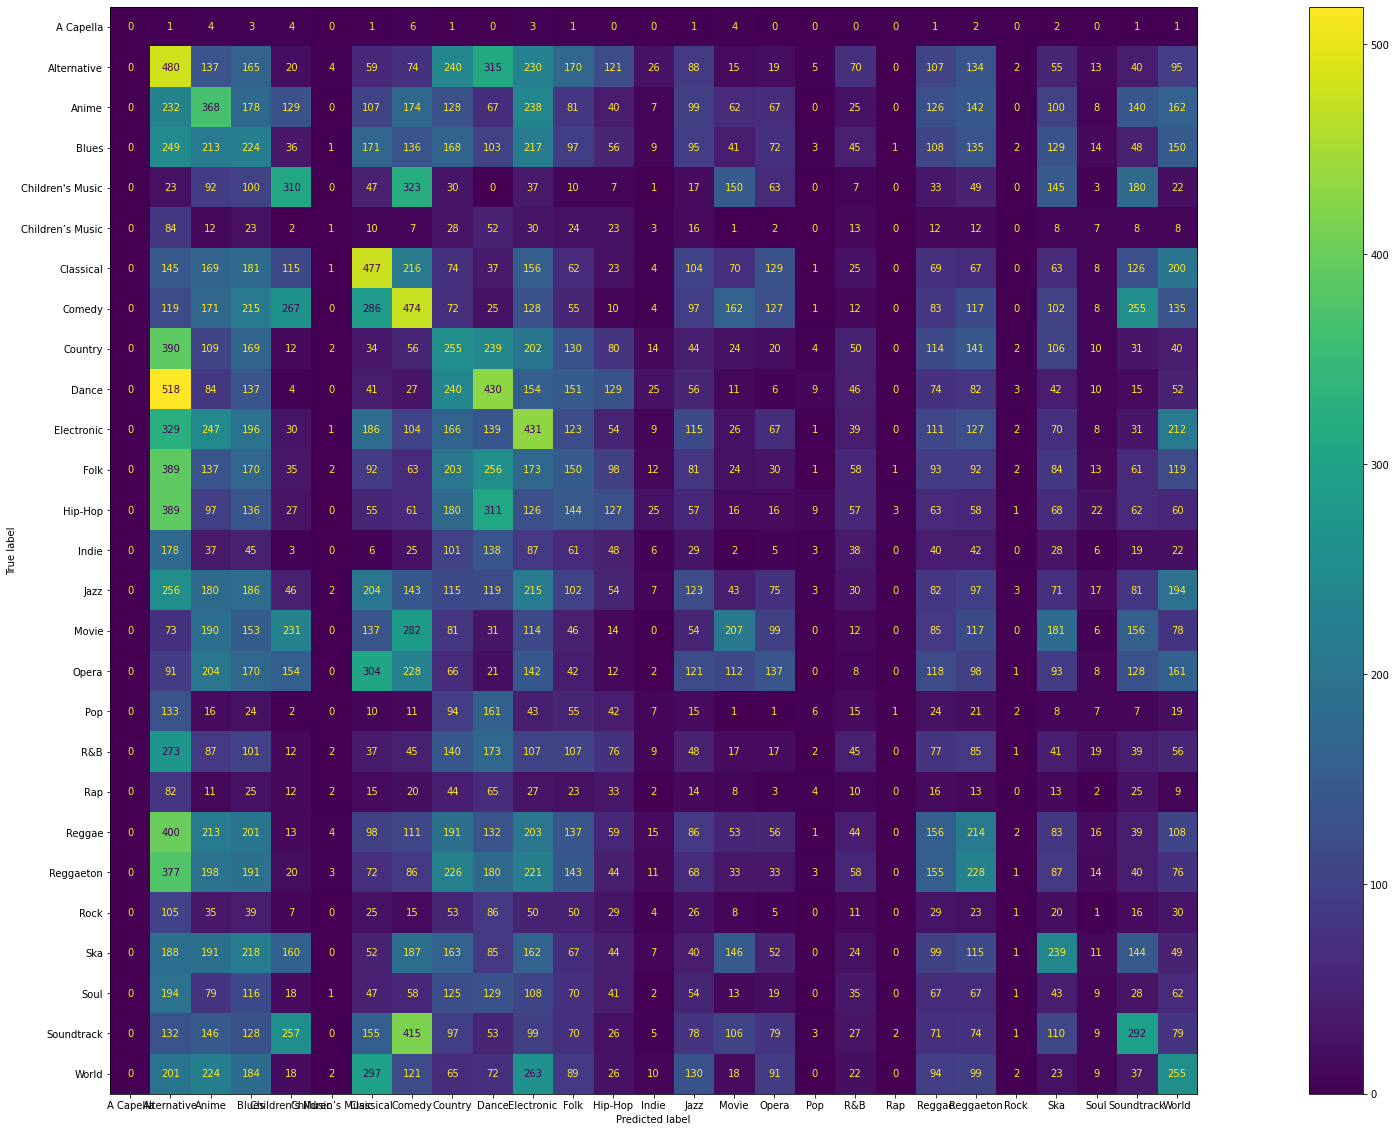

In [74]:
fig, ax = plt.subplots(figsize=(40, 20))
plot_confusion_matrix(neigh, X_test, y_test, ax=ax)  
plt.show()

In [75]:
neigh = KNeighborsClassifier(n_neighbors=26)
neigh.fit(X_deleted_all_duplicates_train, y_deleted_all_duplicates_train)
print(neigh.score(X_deleted_all_duplicates_test,y_deleted_all_duplicates_test))

0.10944817037298506


In [76]:
y_pred = neigh.predict(X_deleted_all_duplicates_test)
print(classification_report(y_deleted_all_duplicates_test, y_pred))

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

       A Capella       0.00      0.00      0.00        32
     Alternative       0.02      0.00      0.01       574
           Anime       0.10      0.18      0.13      2574
           Blues       0.06      0.08      0.07      2173
Children's Music       0.17      0.21      0.19      1585
Children’s Music       0.00      0.00      0.00       171
       Classical       0.16      0.18      0.17      2403
          Comedy       0.13      0.17      0.14      2857
         Country       0.09      0.16      0.11      1925
           Dance       0.07      0.03      0.04       834
      Electronic       0.11      0.16      0.13      2455
            Folk       0.04      0.02      0.03      1330
         Hip-Hop       0.05      0.00      0.01       582
           Indie       0.03      0.00      0.01       616
            Jazz       0.07      0.05      0.06      2153
           Movie       0.13      0.09      0.10      2250
           Op

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


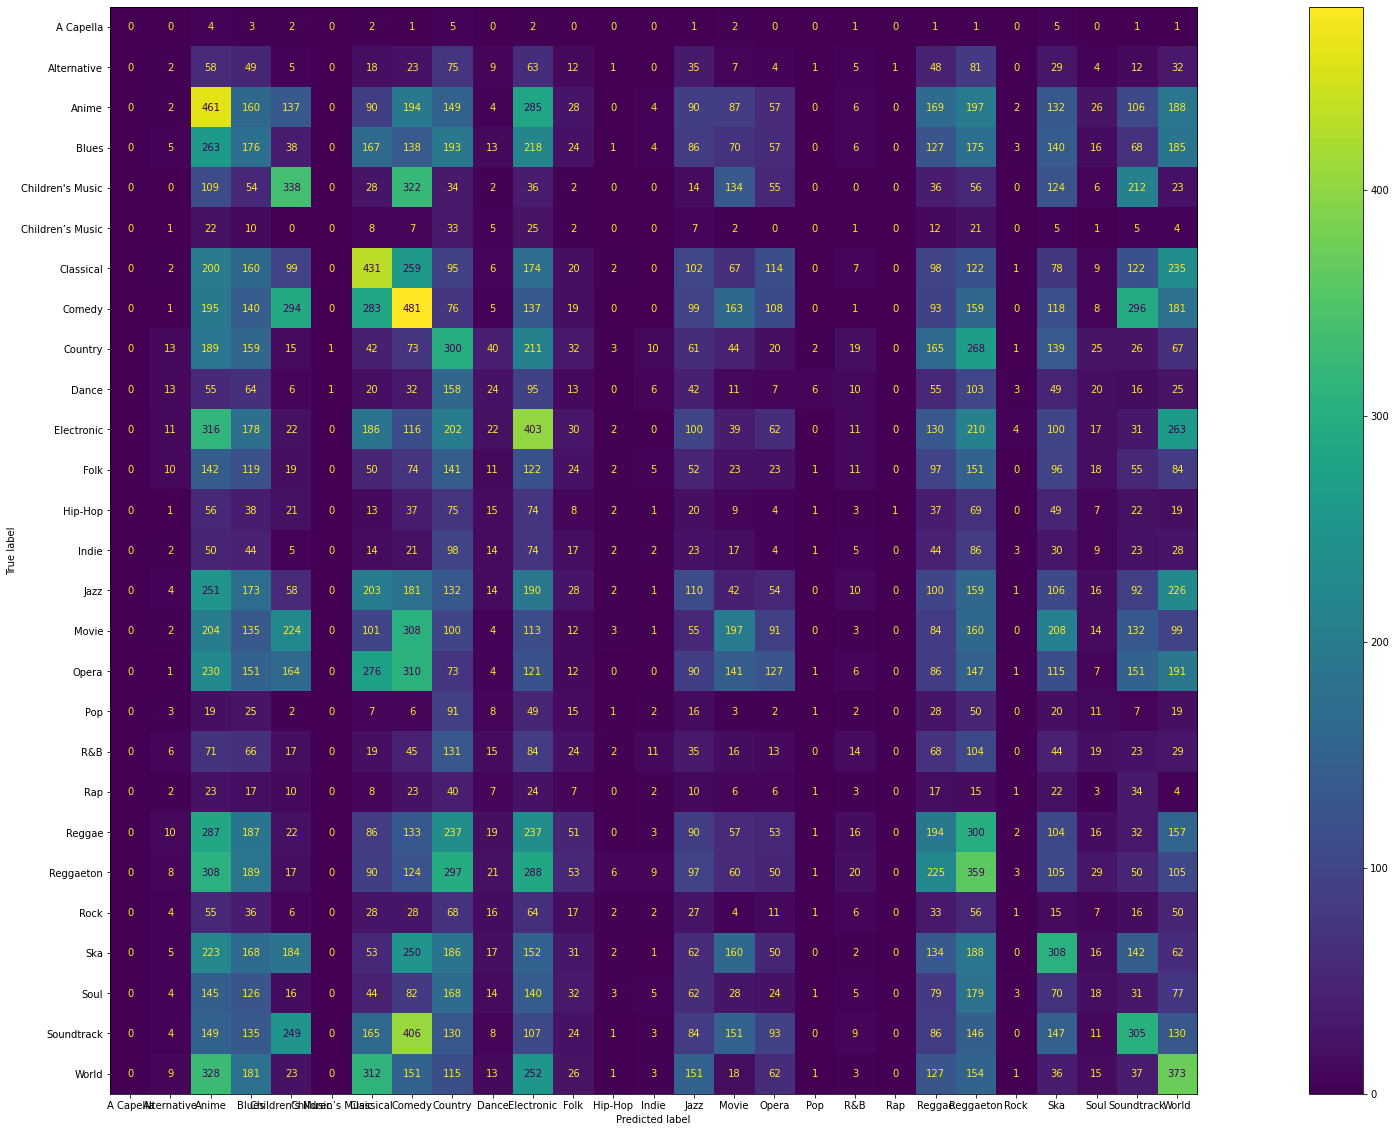

In [77]:
fig, ax = plt.subplots(figsize=(40, 20))
plot_confusion_matrix(neigh, X_deleted_all_duplicates_test, y_deleted_all_duplicates_test, ax=ax)  
plt.show()

In [78]:
neigh = KNeighborsClassifier(n_neighbors=26)
neigh.fit(X_all_train, y_all_train)
print(neigh.score(X_all_test,y_all_test))

0.08444813658368902


In [79]:
y_pred = neigh.predict(X_all_test)
print(classification_report(y_all_test, y_pred))

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

       A Capella       0.00      0.00      0.00        33
     Alternative       0.04      0.09      0.06      2788
           Anime       0.10      0.12      0.11      2640
           Blues       0.06      0.08      0.06      2684
Children's Music       0.17      0.19      0.18      1629
Children’s Music       0.04      0.04      0.04      2860
       Classical       0.15      0.18      0.16      2810
          Comedy       0.13      0.14      0.13      2956
         Country       0.06      0.10      0.07      2648
           Dance       0.08      0.10      0.09      2628
      Electronic       0.09      0.12      0.11      2877
            Folk       0.05      0.05      0.05      2793
         Hip-Hop       0.06      0.05      0.05      2781
           Indie       0.06      0.07      0.07      2842
            Jazz       0.07      0.07      0.07      2832
           Movie       0.17      0.09      0.12      2372
           Op

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pour le KNN, on obtient les score :
* data_genre : 8%
* data_genre_unique : 10%
* data_genre_deleted_all_duplicates : 11%

#### ii) Impact de la normalisation

0.4413101276563649


C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


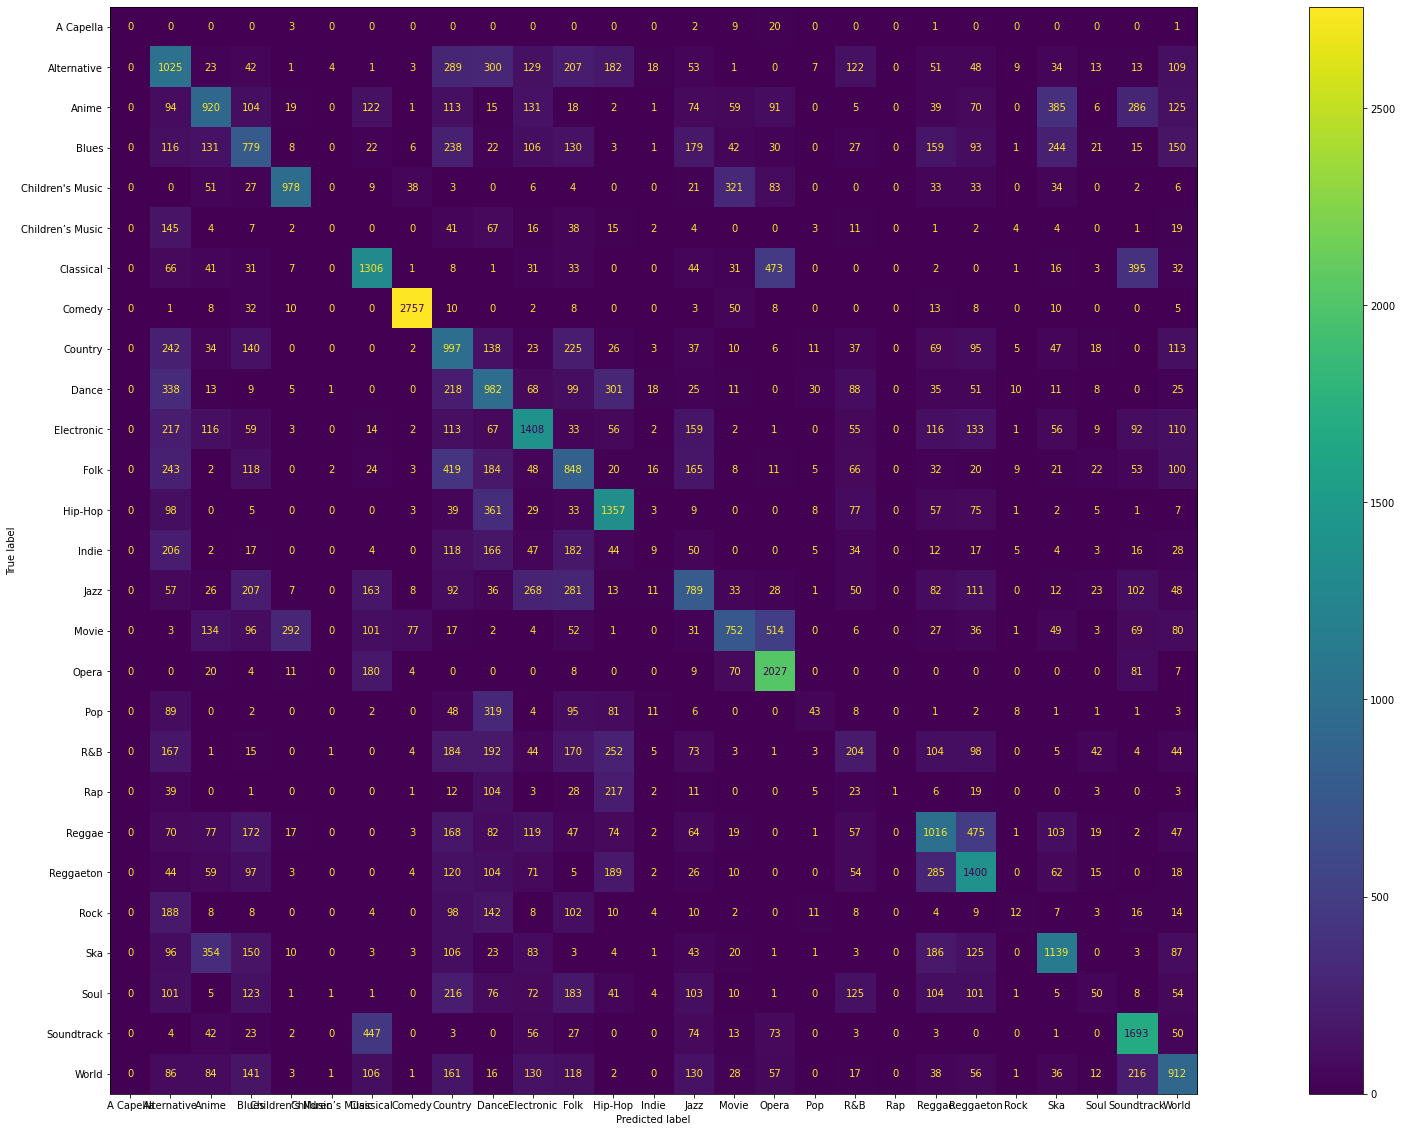

In [105]:
neigh_norm = KNeighborsClassifier(n_neighbors=26)
neigh_norm.fit(X_train_norm, y_train_norm)
print(neigh_norm.score(X_test_norm,y_test_norm))


fig, ax = plt.subplots(figsize=(40, 20))
plot_confusion_matrix(neigh_norm, X_test_norm, y_test_norm, ax=ax)  
plt.show()

Pour la normalisation, on obtient un score de 41%

#### iii) Impact de la limitation des genres de musique

In [81]:
neigh_lim = KNeighborsClassifier(n_neighbors=4)
neigh_lim.fit(X_train_lim, y_train_lim)
print(neigh_lim.score(X_test_lim,y_test_lim))

0.3532170324516976


In [82]:
y_pred_lim = neigh_lim.predict(X_test_lim)
print(classification_report(y_test_lim,y_pred_lim))

              precision    recall  f1-score   support

   Classical       0.39      0.49      0.43      2602
  Electronic       0.35      0.42      0.38      2758
     Hip-Hop       0.39      0.34      0.36      2225
        Jazz       0.28      0.22      0.25      2392
        Rock       0.14      0.04      0.06       685

    accuracy                           0.35     10662
   macro avg       0.31      0.30      0.30     10662
weighted avg       0.34      0.35      0.34     10662



In [83]:
neigh_lim = KNeighborsClassifier(n_neighbors=4)
neigh_lim.fit(X_train_lim_norm, y_train_lim_norm)
print(neigh_lim.score(X_test_lim_norm,y_test_lim_norm))

0.7581129244044269


In [84]:
y_pred_lim = neigh_lim.predict(X_test_lim_norm)
print(classification_report(y_test_lim_norm,y_pred_lim))

              precision    recall  f1-score   support

   Classical       0.83      0.89      0.86      2602
  Electronic       0.69      0.77      0.73      2758
     Hip-Hop       0.83      0.87      0.85      2225
        Jazz       0.71      0.58      0.64      2392
        Rock       0.64      0.46      0.54       685

    accuracy                           0.76     10662
   macro avg       0.74      0.71      0.72     10662
weighted avg       0.75      0.76      0.75     10662



* Limitation des genres de musique : 35%
* Limitation des genres de musique + normalisation : 76%

#### iiii) PCA et limite de feature

In [86]:
def find_pca_norm():
    liste_components = np.arange(1,15,1)
    n = len(liste_components)
    liste_resultats = []
    liste_resultats_lim = []
    for k in range(n):
        pca = PCA(n_components=liste_components[k])
        pca_lim = PCA(n_components=liste_components[k])
        pca.fit(X_norm)
        pca_lim.fit(X_norm)
        X_pca_norm = pca.transform(X_train_norm)
        X_pca_lim_norm = pca.transform(X_train_lim_norm)
        X_test_pca_norm = pca.transform(X_test_norm)
        X_test_pca_lim_norm = pca.transform(X_test_lim_norm)
        neigh = KNeighborsClassifier(n_neighbors=26)
        neigh_lim = KNeighborsClassifier(n_neighbors=4)
        neigh.fit(X_pca_norm,y_train)
        neigh_lim.fit(X_pca_lim_norm,y_train_lim)
        liste_resultats.append([neigh.score(X_test_pca_norm,y_test),liste_components[k]])
        liste_resultats_lim.append([neigh_lim.score(X_test_pca_lim_norm,y_test_lim),liste_components[k]])
    return (liste_resultats,liste_resultats_lim)

find_pca_norm()

([[0.12686440518167932, 1],
  [0.19061716289857258, 2],
  [0.2836912865574265, 3],
  [0.27677106707144605, 4],
  [0.30217034676522164, 5],
  [0.3267588105519205, 6],
  [0.3662813719759395, 7],
  [0.411159089623442, 8],
  [0.4222088133803481, 9],
  [0.4294684441762676, 10],
  [0.4384439877057681, 11],
  [0.4373691852242943, 12],
  [0.4394622216355854, 13],
  [0.4413101276563649, 14]],
 [[0.46088913899831174, 1],
  [0.5088163571562558, 2],
  [0.5962296004501969, 3],
  [0.5828174826486587, 4],
  [0.6198649409116489, 5],
  [0.6544738323016319, 6],
  [0.7006190208216094, 7],
  [0.7357906584130557, 8],
  [0.7486400300131307, 9],
  [0.750234477583943, 10],
  [0.7591446257737761, 11],
  [0.7567998499343462, 12],
  [0.7579253423372726, 13],
  [0.7581129244044269, 14]])

La PCA nous permet de bien voir l'effet de la limitation des genres de musiques. Les features expliquent un pourcentage plus élévé de la variance de notre modèle.

### c) Random Forest

#### i) Impact des doublons

In [87]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

0.5395697018837328
                  precision    recall  f1-score   support

       A Capella       0.83      0.14      0.24        36
     Alternative       0.34      0.44      0.38      2684
           Anime       0.63      0.57      0.60      2680
           Blues       0.43      0.45      0.44      2523
Children's Music       0.75      0.73      0.74      1649
Children’s Music       0.00      0.00      0.00       386
       Classical       0.67      0.65      0.66      2522
          Comedy       0.97      0.95      0.96      2925
         Country       0.43      0.49      0.46      2278
           Dance       0.33      0.48      0.39      2346
      Electronic       0.57      0.59      0.58      2824
            Folk       0.35      0.49      0.41      2439
         Hip-Hop       0.50      0.76      0.60      2170
           Indie       0.27      0.04      0.07       969
            Jazz       0.48      0.43      0.45      2448
           Movie       0.59      0.54      0.56     

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


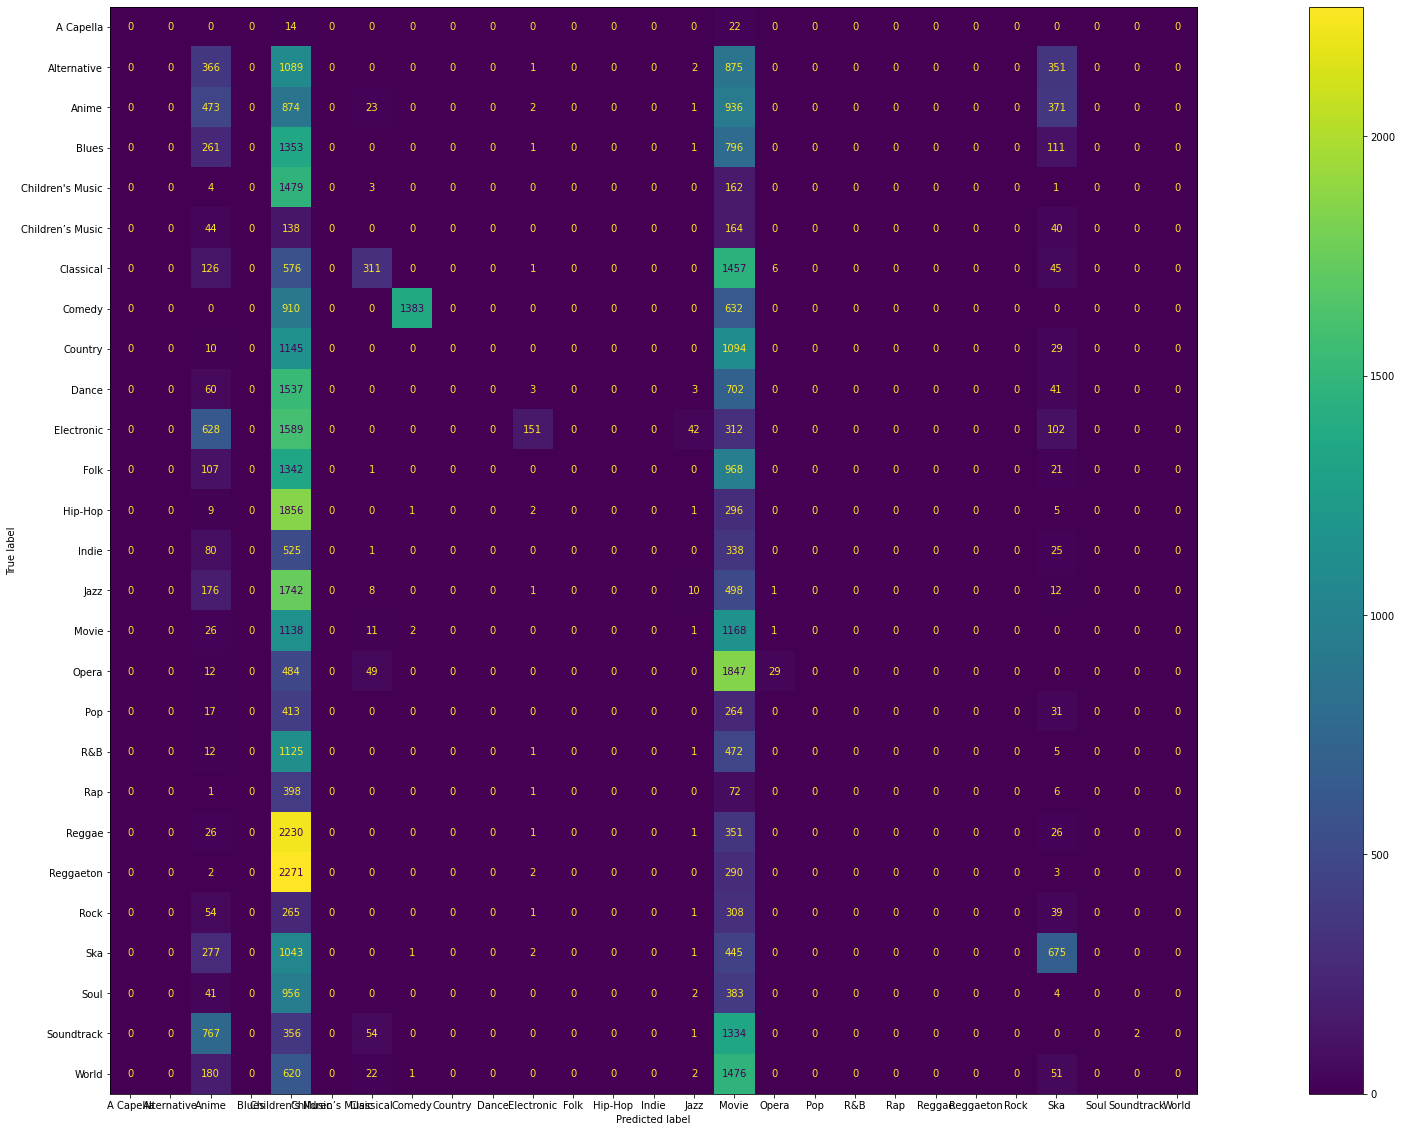

In [88]:
fig, ax = plt.subplots(figsize=(40, 20))
plot_confusion_matrix(clf, X_test_norm, y_test, ax=ax)  
plt.show()

In [89]:
clf.feature_importances_

array([0.13449925, 0.08933523, 0.0896104 , 0.08238908, 0.0777628 ,
       0.07577286, 0.03683228, 0.06497277, 0.080382  , 0.01159092,
       0.10772288, 0.06464557, 0.00774521, 0.07673875])

In [90]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_deleted_all_duplicates_train, y_deleted_all_duplicates_train)
print(clf.score(X_deleted_all_duplicates_test, y_deleted_all_duplicates_test))
y_pred = clf.predict(X_deleted_all_duplicates_test)
print(classification_report(y_deleted_all_duplicates_test, y_pred))

0.5836216025414754
                  precision    recall  f1-score   support

       A Capella       1.00      0.09      0.17        32
     Alternative       0.22      0.06      0.10       574
           Anime       0.63      0.59      0.61      2574
           Blues       0.44      0.47      0.45      2173
Children's Music       0.73      0.75      0.74      1585
Children’s Music       0.08      0.01      0.02       171
       Classical       0.68      0.70      0.69      2403
          Comedy       0.97      0.94      0.95      2857
         Country       0.42      0.63      0.51      1925
           Dance       0.35      0.30      0.32       834
      Electronic       0.56      0.65      0.60      2455
            Folk       0.35      0.35      0.35      1330
         Hip-Hop       0.42      0.45      0.43       582
           Indie       0.32      0.06      0.11       616
            Jazz       0.47      0.48      0.47      2153
           Movie       0.61      0.56      0.59     

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


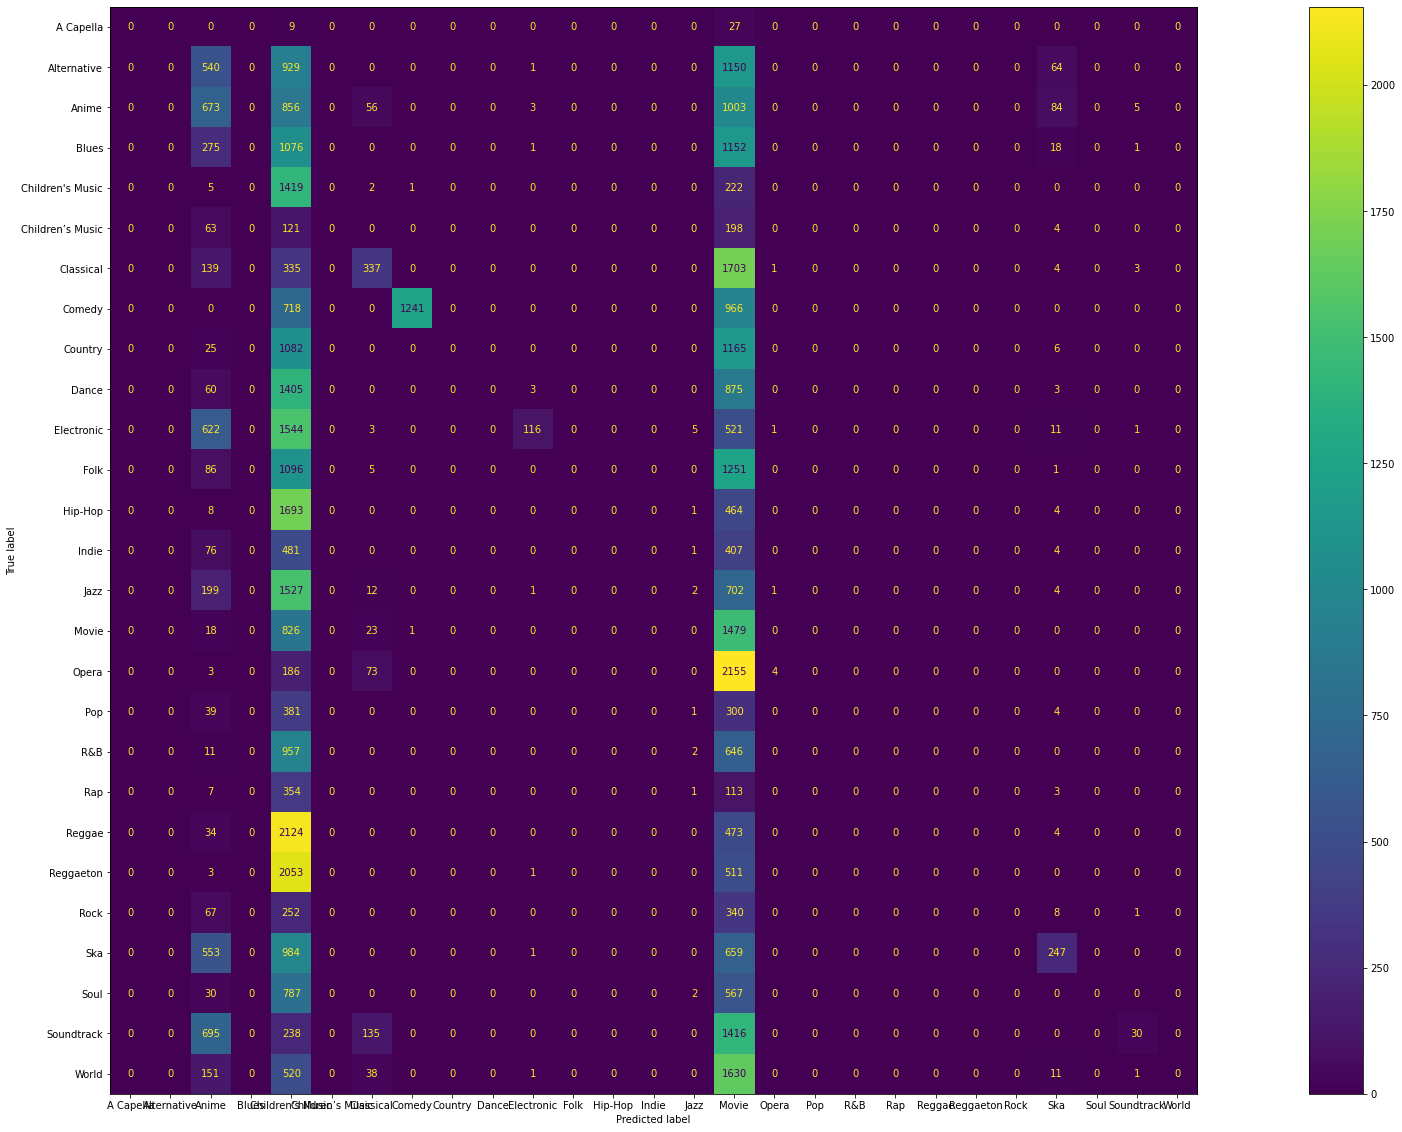

In [91]:
fig, ax = plt.subplots(figsize=(40, 20))
plot_confusion_matrix(clf, X_test_norm, y_test, ax=ax)  
plt.show()

In [92]:
clf.feature_importances_

array([0.13431743, 0.0907769 , 0.0916743 , 0.0839099 , 0.07528931,
       0.08040002, 0.03412888, 0.06702863, 0.07997886, 0.01129183,
       0.10472637, 0.06277136, 0.0076848 , 0.07602144])

In [93]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_all_train, y_all_train)
print(clf.score(X_all_test, y_all_test))
y_pred = clf.predict(X_all_test)
print(classification_report(y_all_test, y_pred))

0.3737861296513793
                  precision    recall  f1-score   support

       A Capella       1.00      0.09      0.17        33
     Alternative       0.14      0.11      0.12      2788
           Anime       0.62      0.56      0.59      2640
           Blues       0.39      0.40      0.40      2684
Children's Music       0.76      0.73      0.75      1629
Children’s Music       0.04      0.04      0.04      2860
       Classical       0.62      0.60      0.61      2810
          Comedy       0.97      0.94      0.96      2956
         Country       0.37      0.40      0.39      2648
           Dance       0.12      0.10      0.11      2628
      Electronic       0.54      0.54      0.54      2877
            Folk       0.20      0.22      0.21      2793
         Hip-Hop       0.14      0.16      0.15      2781
           Indie       0.06      0.05      0.06      2842
            Jazz       0.38      0.37      0.38      2832
           Movie       0.60      0.55      0.57     

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


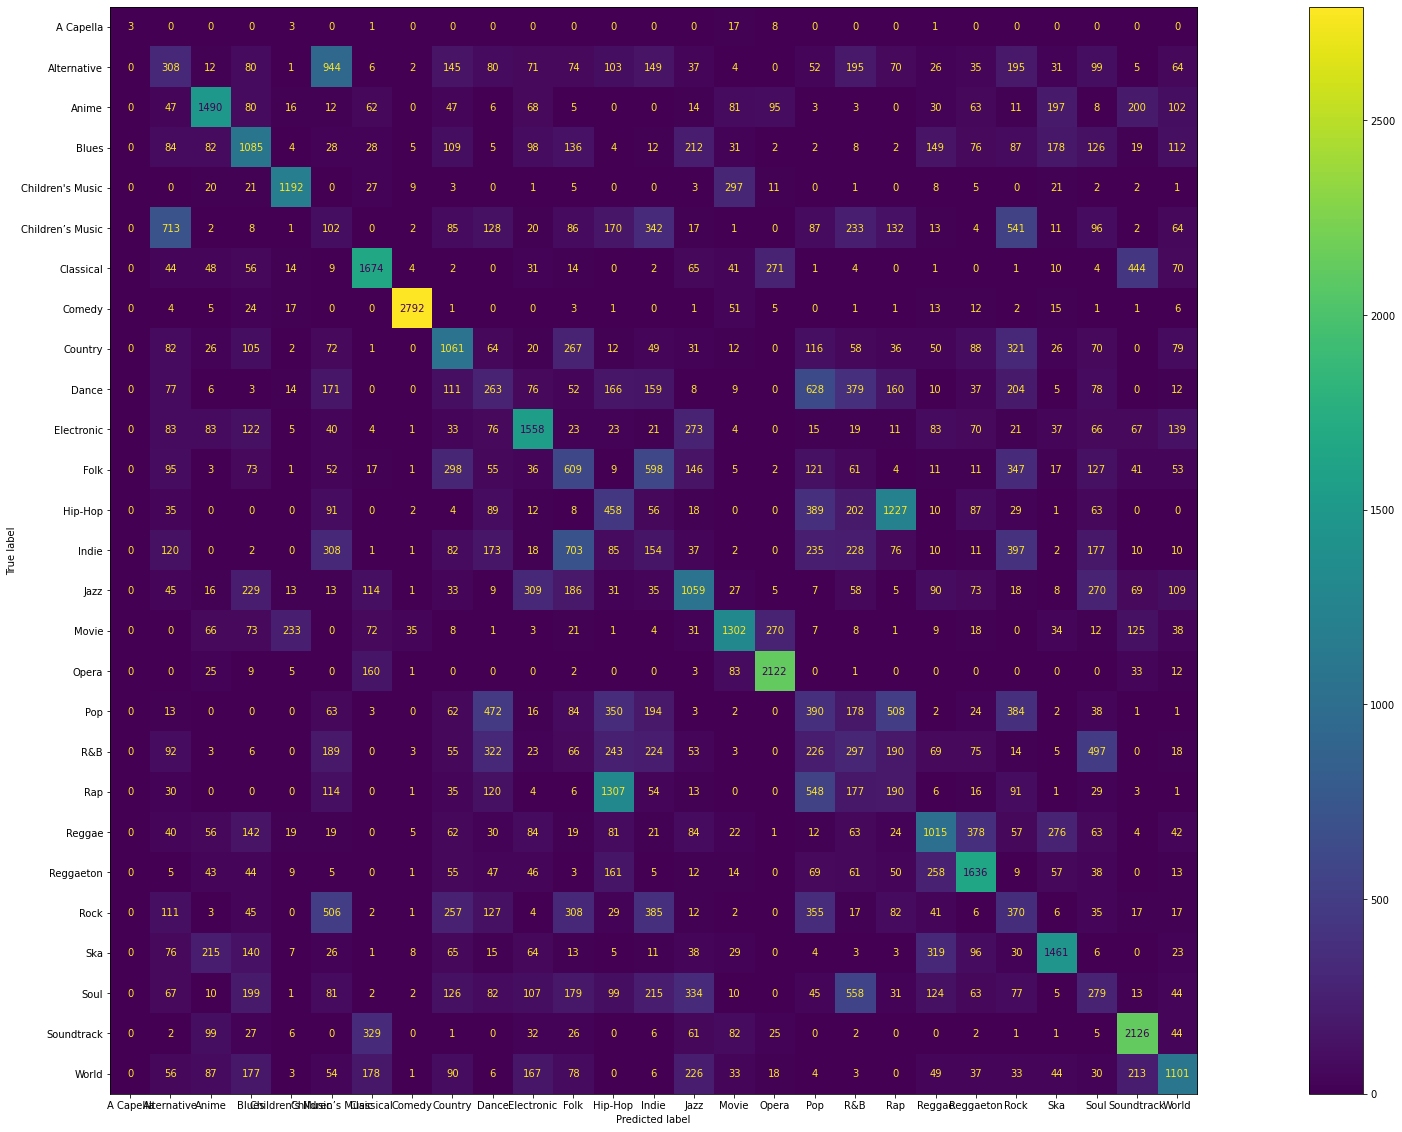

In [94]:
fig, ax = plt.subplots(figsize=(40, 20))
plot_confusion_matrix(clf, X_all_test, y_all_test, ax=ax)  
plt.show()

In [95]:
clf.feature_importances_

array([0.16107616, 0.08471012, 0.08553654, 0.07955934, 0.0762838 ,
       0.07192197, 0.03805954, 0.06405325, 0.07861337, 0.0113334 ,
       0.10182722, 0.06475678, 0.00720217, 0.07506633])

Pour le Random Forest, on obtient les score :
* data_genre : 37%
* data_genre_unique : 54%
* data_genre_deleted_all_duplicates : 58%

#### ii) Impact de la normalisation

In [96]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train_norm, y_train_norm)
print(clf.score(X_test_norm, y_test_norm))
y_pred = clf.predict(X_test_norm)
print(classification_report(y_test_norm, y_pred))

0.5390794411027097
                  precision    recall  f1-score   support

       A Capella       0.80      0.11      0.20        36
     Alternative       0.33      0.43      0.37      2684
           Anime       0.63      0.57      0.60      2680
           Blues       0.43      0.45      0.44      2523
Children's Music       0.76      0.73      0.75      1649
Children’s Music       0.00      0.00      0.00       386
       Classical       0.67      0.65      0.66      2522
          Comedy       0.97      0.95      0.96      2925
         Country       0.42      0.49      0.45      2278
           Dance       0.33      0.48      0.39      2346
      Electronic       0.56      0.60      0.58      2824
            Folk       0.35      0.48      0.40      2439
         Hip-Hop       0.50      0.75      0.60      2170
           Indie       0.20      0.04      0.06       969
            Jazz       0.48      0.43      0.45      2448
           Movie       0.59      0.54      0.56     

C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


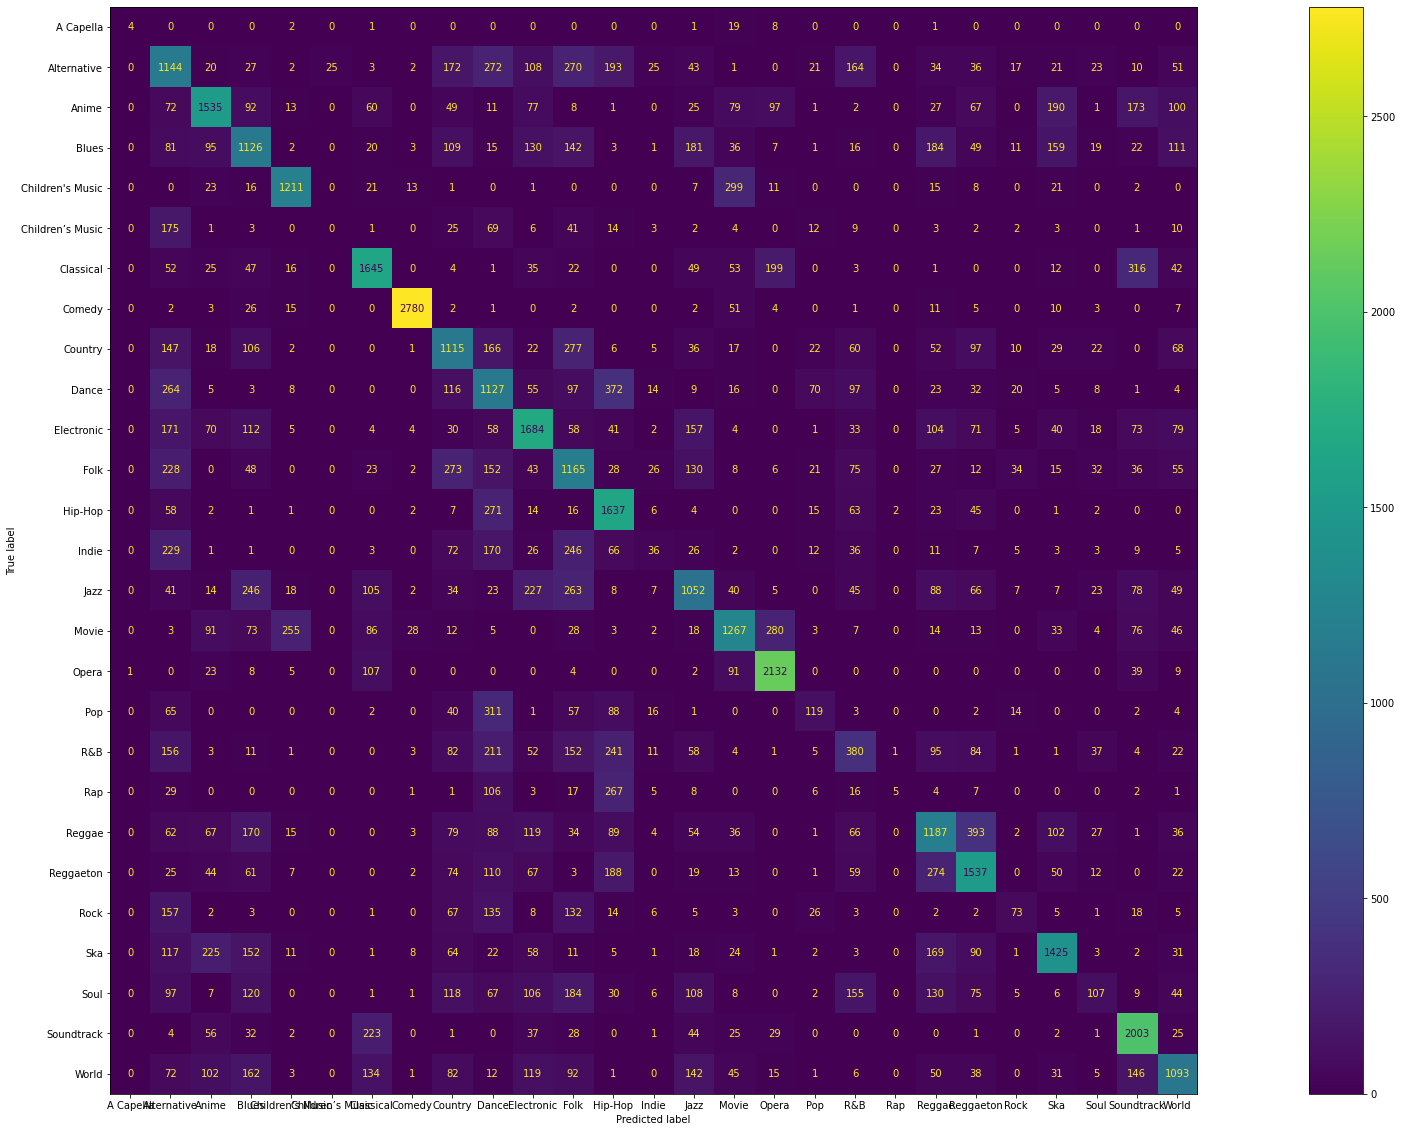

In [97]:
fig, ax = plt.subplots(figsize=(40, 20))
plot_confusion_matrix(clf, X_test_norm, y_test, ax=ax)  
plt.show()

In [98]:
clf.feature_importances_

array([0.13425873, 0.08978076, 0.08985274, 0.08202438, 0.07732432,
       0.07568531, 0.03683262, 0.06508976, 0.08055634, 0.0114491 ,
       0.1074744 , 0.06498281, 0.00764084, 0.0770479 ])

Pour la normalisation : on obtient 54% de f1-score.

#### iii) Impact de la limitation des genres de musique

In [99]:
clf_lim = RandomForestClassifier(random_state=0)
clf_lim.fit(X_train_lim, y_train_lim)
print(clf_lim.score(X_test_lim, y_test_lim))
y_pred_lim = clf_lim.predict(X_test_lim)
print(classification_report(y_test_lim, y_pred_lim))

0.8369911836428438
              precision    recall  f1-score   support

   Classical       0.91      0.90      0.90      2602
  Electronic       0.79      0.81      0.80      2758
     Hip-Hop       0.90      0.93      0.91      2225
        Jazz       0.77      0.74      0.75      2392
        Rock       0.77      0.73      0.75       685

    accuracy                           0.84     10662
   macro avg       0.83      0.82      0.82     10662
weighted avg       0.84      0.84      0.84     10662



C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


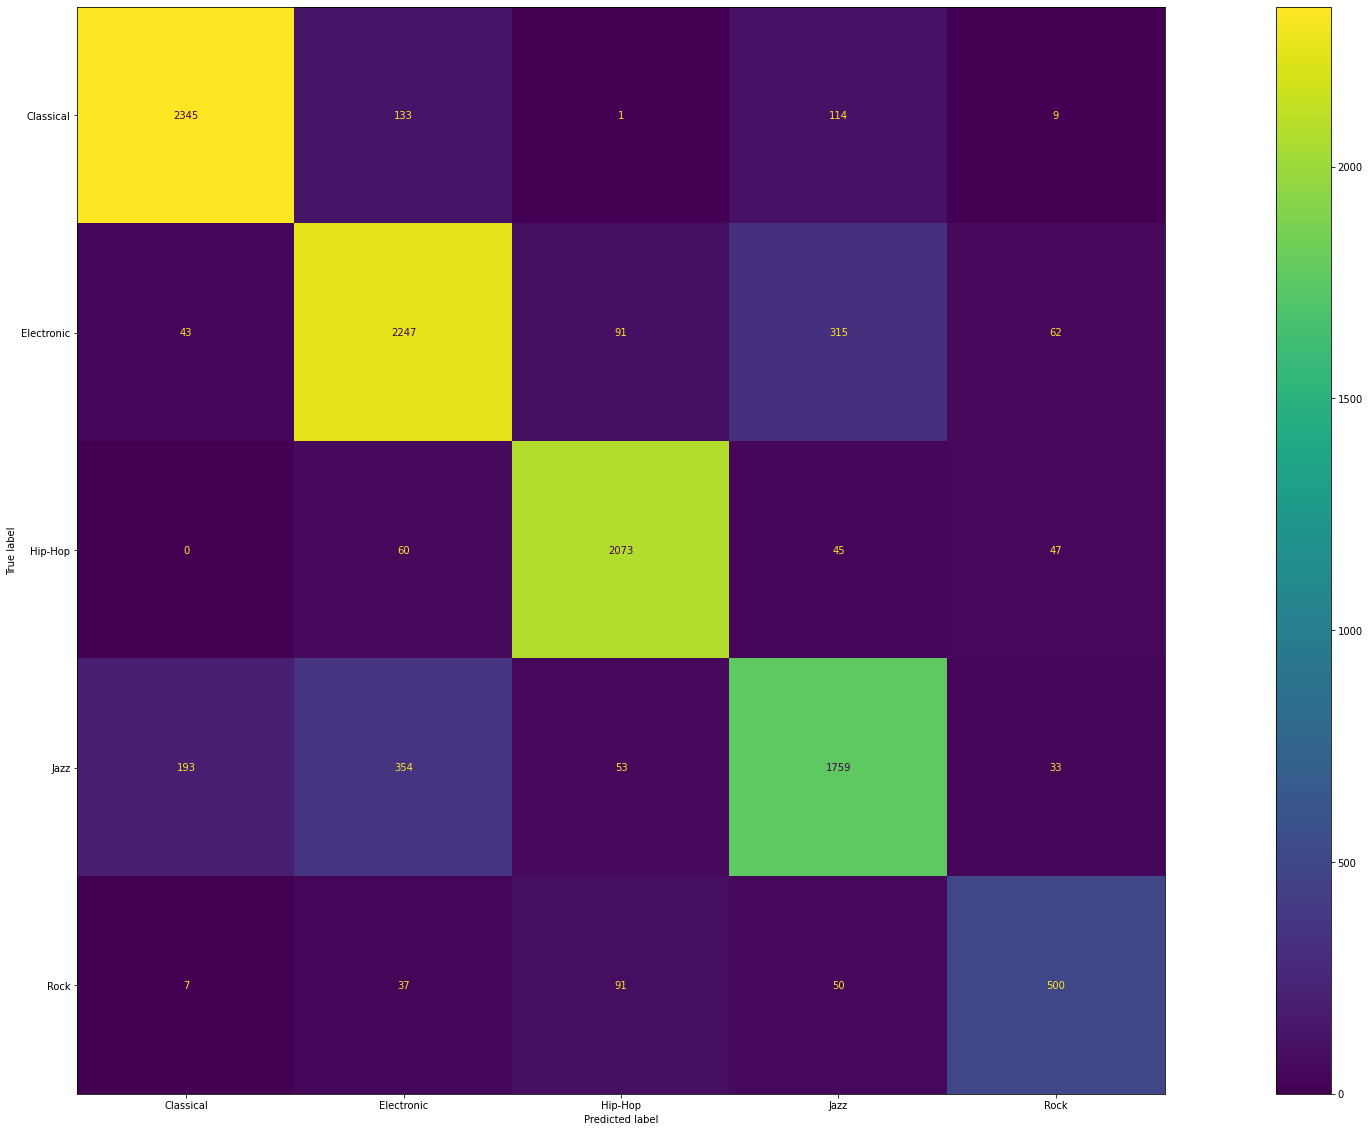

In [100]:
fig, ax = plt.subplots(figsize=(40, 20))
plot_confusion_matrix(clf_lim, X_test_lim, y_test_lim, ax=ax)  
plt.show()

In [101]:
clf_lim.feature_importances_

array([0.16308782, 0.13676226, 0.10952184, 0.03956592, 0.0897756 ,
       0.09712233, 0.01688237, 0.02832593, 0.1235722 , 0.00616922,
       0.08107929, 0.04254008, 0.00592079, 0.05967434])

In [102]:
clf_lim = RandomForestClassifier(random_state=0)
clf_lim.fit(X_train_lim_norm, y_train_lim_norm)
print(clf_lim.score(X_test_lim_norm, y_test_lim_norm))
y_pred_lim = clf_lim.predict(X_test_lim_norm)
print(classification_report(y_test_lim_norm, y_pred_lim))

0.837084974676421
              precision    recall  f1-score   support

   Classical       0.91      0.90      0.90      2602
  Electronic       0.79      0.81      0.80      2758
     Hip-Hop       0.90      0.93      0.92      2225
        Jazz       0.77      0.74      0.75      2392
        Rock       0.77      0.73      0.75       685

    accuracy                           0.84     10662
   macro avg       0.83      0.82      0.83     10662
weighted avg       0.84      0.84      0.84     10662



C:\Users\Jeanl\anaconda3\envs\Data\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


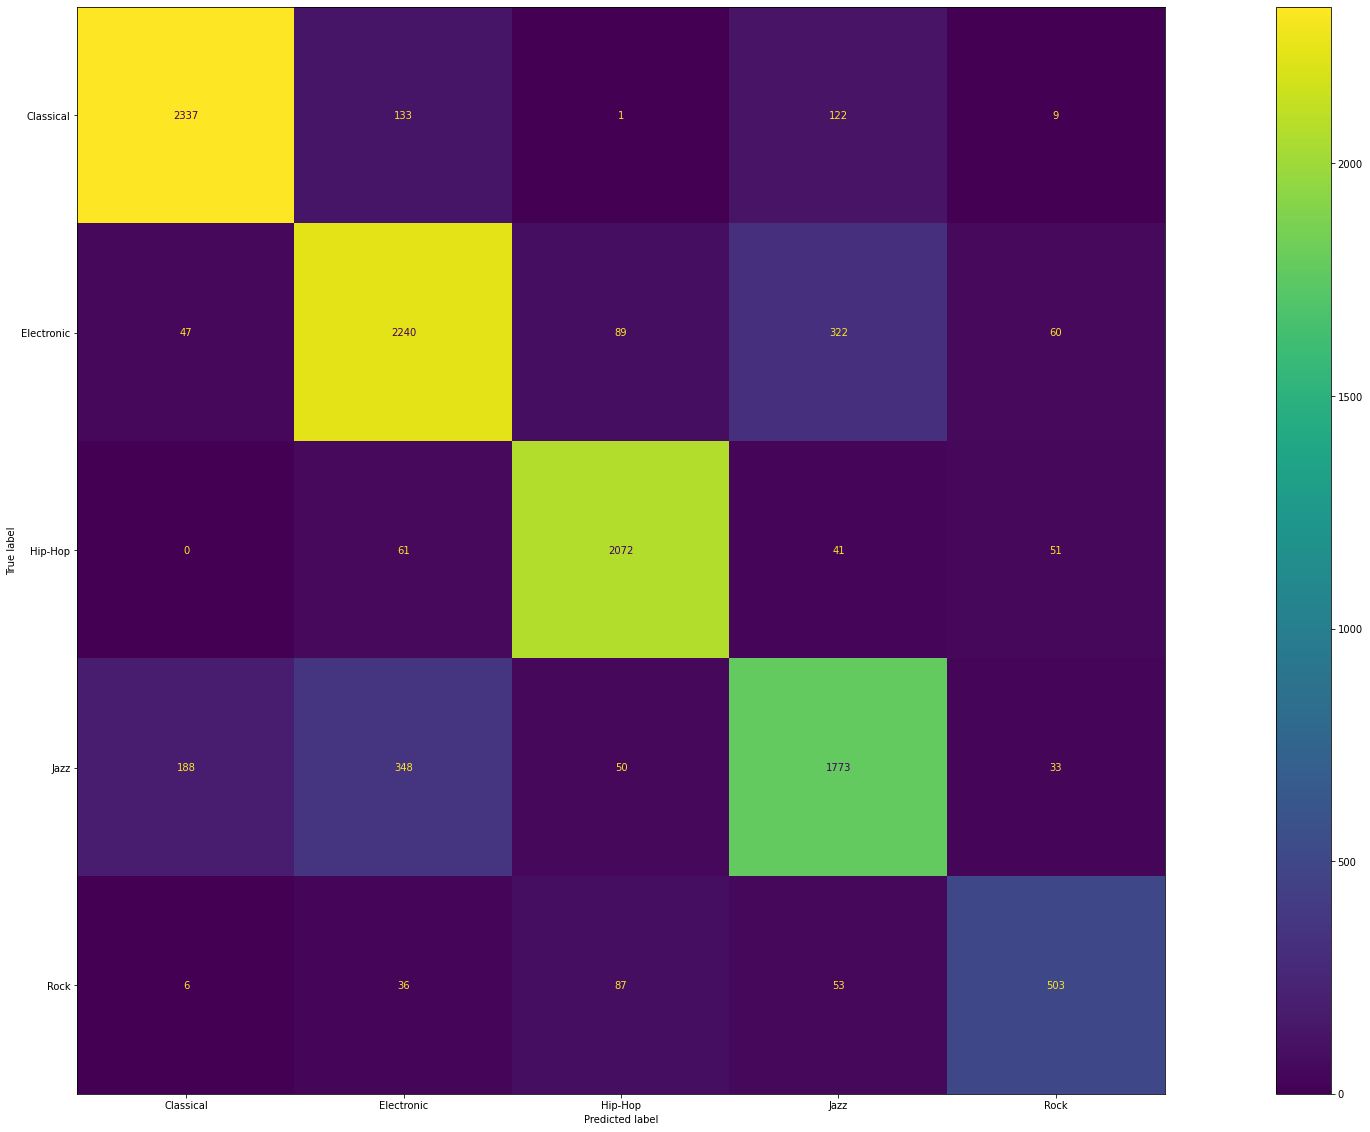

In [103]:
fig, ax = plt.subplots(figsize=(40, 20))
plot_confusion_matrix(clf_lim, X_test_lim_norm, y_test_lim, ax=ax)  
plt.show()

In [104]:
clf_lim.feature_importances_

array([0.162903  , 0.13641561, 0.10934802, 0.03982146, 0.08843495,
       0.09756705, 0.01689677, 0.02830689, 0.12486572, 0.00621563,
       0.08129428, 0.04271033, 0.00591494, 0.05930535])

* Limitation des genres de musique : 84%
* Limitation des genres de musique + normalisation : 84%

 ##### Le meilleur modèle semble donc être celui du random Forest, avec les données normalisés et limités à 5 genres.